In [1]:
#Imports
import networkx as nx
import matplotlib.pylab as plt
import numpy
import json
import statistics
import math
import re

In [2]:
# Create network where nodes correspond to paper IDs and an edge from node A to node B is established if paper A cites paper B.

datafile = open("data.txt", "r", encoding="utf-8")
graph = nx.DiGraph()

process_paper = 0
print("Creating graph..")
for line in datafile.readlines():
    if (line.startswith("#index")):
        process_paper = int(line.split("index")[1])
        graph.add_node(process_paper)
    elif (line.startswith("#%")):
        edge_to = int(line.split("%")[1])
        graph.add_edge(process_paper, edge_to)
        # debug
        #nx.draw_networkx(graph)
        #plt.show()

print("Graph generation done\n\n")
print(graph)

Creating graph..
Graph generation done


DiGraph with 629814 nodes and 632751 edges


In [3]:
#--1--
#Get main global characteristics of the graph

#Number of nodes/edges
print("Number of edges: ", graph.number_of_edges())
print("Number of nodes: ", graph.number_of_nodes())
number_of_nodes = graph.number_of_nodes()

#Convert to undirected to calculate diameter
G1_1 = graph.to_undirected()
try:
    diameter = nx.diameter(G1_1)
    print("Network diameter:  ", diameter)
except nx.NetworkXError:
    print("Network diameter: infinity (Disconnect Graph)")
    
#TODO: estimate of diameter

#Average clustering coefficient
print("Avg Clustering coefficient: ", nx.average_clustering(graph))

#Get number of strongly and weakly connected components
num_strongly_connected = 0
num_weakly_connected = 0
for c in sorted(nx.strongly_connected_components(graph), key=len, reverse=True):
    num_strongly_connected += 1
for c in sorted(nx.weakly_connected_components(graph), key=len, reverse=True):
    num_weakly_connected += 1
print("Number of (strongly) connected components: ", num_strongly_connected)
print("Number of (weakly) connected components: ", num_weakly_connected)

#Calculate average degree centrality
degree_centrality = nx.degree_centrality(graph)
temptot = 0
for item in degree_centrality:
    temptot += degree_centrality[item]
print("Avg degree centrality: ", temptot/len(degree_centrality))

Number of edges:  632751
Number of nodes:  629814
Network diameter: infinity (Disconnect Graph)
Avg Clustering coefficient:  0.014596524203392774
Number of (strongly) connected components:  628549
Number of (weakly) connected components:  416924
Avg degree centrality:  3.190354221130881e-06


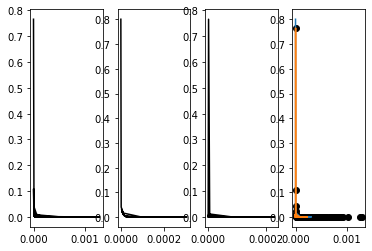

In [4]:
#--2--
#Save in-degree/out-degree/PageRank centralities to file and plot their distribution

degreefile = open("degreefile.txt", "w")
indegreecent = nx.algorithms.centrality.in_degree_centrality(graph)
outdegreecent = nx.algorithms.centrality.out_degree_centrality(graph)
pagerankcent = nx.pagerank(graph)

# Save centralities to file
degreefile.writelines("IN DEGREE:\n")
for item in indegreecent:
    degreefile.writelines("{}: {}\n".format(item, indegreecent[item]))
degreefile.writelines("\n\nOUT DEGREE:\n")
for item in outdegreecent:
    degreefile.writelines("{}: {}\n".format(item, outdegreecent[item]))
degreefile.writelines("\n\nPAGERANK:\n")
for item in pagerankcent:
    degreefile.writelines("{}: {}\n".format(item, pagerankcent[item]))


# function to get distributions
def centrality_distributions(dic):
    # init x and y
    x = [0]*1
    y = [0]*1
    for key in dic:
        if dic[key] not in x:
            x.append(dic[key])
            y.append(0)
        y[x.index(dic[key])] += 1
    y = [y_item / number_of_nodes for y_item in y]
    return x, y

# in degree centrality distribution
f, (ax1, ax2, ax3, ax4) = plt.subplots(1,4)
x_id, y_id = centrality_distributions(indegreecent)
ax1.plot(x_id, y_id, color='black')
ax4.plot(x_id, y_id,'o', color='black')

# out degree centrality distribution
x_od, y_od = centrality_distributions(outdegreecent)
ax2.plot(x_od, y_od, color='black')
ax4.plot(x_od, y_od)

# pagerank degree centrality distribution
x_pr, y_pr = centrality_distributions(pagerankcent)
ax3.plot(x_pr, y_pr, color='black')
ax4.plot(x_pr, y_pr)

plt.show()

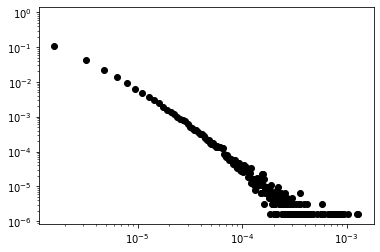

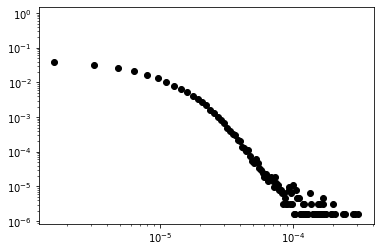

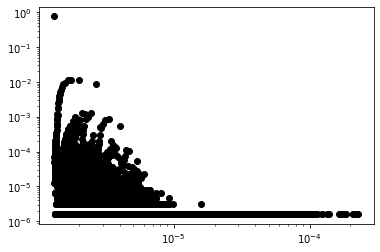

In [5]:
#--3--
#Check how well power law distribution can be fit to degrees calcualted in previus step

#TODO: fit lines

plt.yscale("log")
plt.xscale("log")

#x_id_log = [log(val,10) for val in x_id]
#y_id_log = [log(val,10) for val in y_id]
plt.plot(x_id, y_id,'o', color='black')
#plt.plot(x_id_log, y_id_log,'o', color='black')
plt.show()

plt.yscale("log")
plt.xscale("log")

#x_od_log = [log(val,10) for val in x_od]
#y_od_log = [log(val,10) for val in y_od]
plt.plot(x_od, y_od,'o', color='black')
#plt.plot(x_od_log, y_od_log,'o', color='black')
plt.show()

plt.yscale("log")
plt.xscale("log")

#x_pr_log = [log(val,10) for val in x_pr]
#y_pr_log = [log(val,10) for val in y_pr]
plt.plot(x_pr, y_pr,'o', color='black')
#plt.plot(x_pr_log, y_pr_log,'o', color='black')
plt.show()

In [6]:
#--5--Preparation
#In task 5, we need to look how well communities identified in task 4 fit to publication venue info so do
#some preparations before starting task 4.


# Create dict of paper-publishvenue
dataf = open("data.txt", "r", encoding="utf-8")
publishdict = {}
for line in dataf.readlines():
    if line.startswith("#c") or line.startswith("#index"):
        try:
            publishplace = line.split("#c")[1].strip("\n")
        except Exception:
            paper = line.split("#index")[1].strip("\n")
            publishdict[paper] = publishplace
dataf.close()


#Helper function to get data ready for task 5. This will be called with each identified community in task 4.
#Output to file will include number of each identified publication venue in each community.
teht5 = open("teht5.txt", "w")
subnum = 0
def t_5(subgraph):
    global subnum
    venues = {}
    for node in subgraph.nodes():
        try:
            venue = publishdict[str(node)] #Try getting venue
        except Exception:
            venue = "" #If not found, venue=""

        try:
            num_venue = int(venues[venue]) #How many times the same venue has already been found?
        except Exception:
            num_venue = 0

        venues[venue] = str(num_venue + 1)
    
    teht5.writelines("subgraph: {}\n".format(subnum))
    teht5.write(json.dumps(venues))
    teht5.writelines("\n\n")
    subnum += 1

In [7]:
#--4--PREPARATION
#Label propagation implementation of networkX only works on undirected graphs so recreate graph as undirected

nondirectedgraph = nx.Graph()
process_paper = 0
print("Creating nondirected graph..")
datafile.close()
datafile = open("data.txt", "r", encoding="utf-8")

for line in datafile.readlines():
    if (line.startswith("#index")):
        process_paper = int(line.split("index")[1])
        nondirectedgraph.add_node(process_paper)
    elif (line.startswith("#%")):
        edge_to = int(line.split("%")[1])
        nondirectedgraph.add_edge(process_paper, edge_to)

print("Graph generation done\n\n")

# Get communities
print("Getting communities..")
communities = nx.algorithms.community.label_propagation_communities(nondirectedgraph)
print("Getting communities done!")

subgraphfile = open("subgraphs.txt", "w")
i = 0
print("Saving community info to file")
for community in communities:
    subgraph = nondirectedgraph.subgraph(community).copy()

    t_5(subgraph) #Do preparation for task 5

    #print("\n\nsubgraph: {}\n".format(i))
    #Try writing info about current communitys nodes/edges/average clustering/diameter to file
    subgraphfile.writelines("\n\nsubgraph: {}".format(i))
    try:
        #print("Number of edges: ", subgraph.number_of_edges())
        subgraphfile.writelines(" Number of edges: {}".format(subgraph.number_of_edges()))
        #print("Number of nodes: ", subgraph.number_of_nodes())
        subgraphfile.writelines(" Number of nodes: {}".format(subgraph.number_of_nodes()))
        #print("Avg Clustering coefficient: ", nx.average_clustering(subgraph))
        subgraphfile.writelines(" Avg Clustering coefficient: {}".format(nx.average_clustering(subgraph)))
        #print("Diameter: " + str(nx.diameter(subgraph)))  # Will fail if not strongly connected
        subgraphfile.writelines(" Diameter: " + str(nx.diameter(subgraph)))
    except Exception as e:
        #print("Error: ", str(e))
        subgraphfile.writelines("Error: {}".format(str(e)))
    subgraphfile.writelines("\n")
    i += 1
subgraphfile.close()
print("Preparation done\n")



#--4--ANALYSIS
#Get summarised data about the communities

print("Start analysis\n")
file = open("subgraphs.txt")
dc = {"graphs": [], "edges": [], "nodes": [], "clust": [], "diam": []}
num_single_node = 0

#Extract info on edges, nodes, clustering coefficients and diametes to lists in dictionary for easy processing
for line in file.readlines():
    sp = line.strip("\n").split(" ")
    if len(sp) > 1:
        subgraph = sp[1]
        edges = sp[5]
        nodes = sp[9]
        avg_clustering = sp[13]
        diameter = sp[15]
        dc["graphs"].append(float(subgraph))
        dc["edges"].append(float(edges))
        if edges == "0":
            num_single_node += 1
        dc["nodes"].append(float(nodes))
        dc["clust"].append(float(avg_clustering.strip("Error:")))
        try:
            dc["diam"].append(float(diameter))
        except Exception:
            pass
print(num_single_node)

#Print all the summaries
print("avg nodes: " + str(sum(dc["nodes"])/len(dc["nodes"])))
print("median nodes: "+ str(statistics.median(dc["nodes"])))
print("variance nodes: " + str(statistics.variance(dc["nodes"])))
print("stantard deviation nodes: " + str(statistics.stdev(dc["nodes"])))
print("\n\n")
print("avg edges: " + str(sum(dc["edges"])/len(dc["edges"])))
print("median edges: "+ str(statistics.median(dc["edges"])))
print("variance edges: " + str(statistics.variance(dc["edges"])))
print("stantard deviation edges: " + str(statistics.stdev(dc["edges"])))
print("\n\n")
print("avg clust: " + str(sum(dc["clust"])/len(dc["clust"])))
print("median clust: "+ str(statistics.median(dc["clust"])))
print("variance clust: " + str(statistics.variance(dc["clust"])))
print("stantard deviation clust: " + str(statistics.stdev(dc["clust"])))
print("\n\n")
print("avg diam: " + str(sum(dc["diam"])/len(dc["diam"])))
print("median diam: "+ str(statistics.median(dc["diam"])))
print("variance diam: " + str(statistics.variance(dc["diam"])))
print("stantard deviation diam: " + str(statistics.stdev(dc["diam"])))

Creating nondirected graph..
Graph generation done


Getting communities..
Getting communities done!
Saving community info to file
Preparation done

Start analysis

412479
avg nodes: 1.4165697641726926
median nodes: 1.0
variance nodes: 426.04114342324254
stantard deviation nodes: 20.64076411917065



avg edges: 0.8111559699058715
median edges: 0.0
variance edges: 4093.896207560862
stantard deviation edges: 63.983562010573166



avg clust: 0.003883411941403397
median clust: 0.0
variance clust: 0.0023244931582678085
stantard deviation clust: 0.0482129978145708



avg diam: 0.1300803495690014
median diam: 0.0
variance diam: 0.30202999520897883
stantard deviation diam: 0.5495725568193692


Histogram of agreement


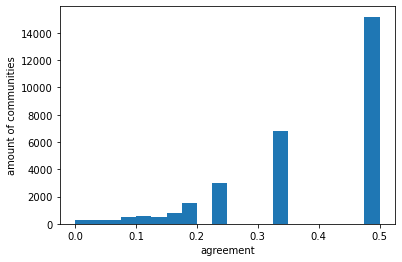

In [8]:
#--5--Analysis
#Look for how well publication venue agrees with community extraction of previous task

def do_analysis_5():
    teht5file = open("teht5.txt", "r")
    community = 0
    #Loop every community
    for line in teht5file.readlines():
        if line.startswith("{"):
            venuedict = json.loads(line)
            analysedict(venuedict, community) #Get agreement value 1/(num identified venues)
        if line.startswith("subgraph"):
            community += 1
    draw_histogram()

ylistall = [] #All values
ylist_not1 = [] #Ignoring single node communities (as for them agreement always 1/1)
def analysedict(venues, community):
    agreement = 1 / len(venues)
    ylistall.append(agreement)
    if len(venues) > 1:
        ylist_not1.append(agreement)

#Draw histogram
def draw_histogram():
    print("Histogram of agreement")
    #plt.hist(ylistall)
    plt.xlabel("agreement")
    plt.ylabel("amount of communities")
    plt.hist(ylist_not1, bins=20)
    plt.show()
    
do_analysis_5()

In [9]:
#--6--
#Create new graph where nodes are authors and links between them idicate co-written paper

datafile = open("data.txt", "r", encoding="utf-8")
graph = nx.Graph()

# Generate graph
print("Generating graph..")
for line in datafile.readlines():
    if (line.startswith("#@")):
        # For evey author line:
        splitted = line.strip("\n").split(",") #strip \n + split ,
        splitted[0] = splitted[0].strip("#@")
        
        donepairs = []
        donelist = []
        for j in range(len(splitted)):
            #for each author in line
            person1 = splitted[j].strip("\n")
            donelist.append(person1)
            if len(splitted) == 1: #Just add node
                graph.add_node(person1) 
            
            else: #Add edge
                for i in range(len(splitted)):
                    # for each author in line
                    person2 = splitted[i].strip("\n")
                    alreadydone = False
                    
                    # Loop through all done pairs and if item contains both names -> skip
                    for item in donepairs:
                        if person1 in item and person2 in item:
                            alreadydone = True

                    if not alreadydone:
                        # Filter away some random "names"
                        # Line "Chuck Barritt,Alderman F. Lee, Jr." => ["Chuck Barritt", "Alderman F. Lee", " Jr."]
                        # so skip if person1 and person 2 the same or startswith space
                        if person1 != person2 and not person1.startswith(" ") and not person2.startswith(" ") and person2 not in donelist:
                            # If connection already get weighth
                            weight = graph.get_edge_data(person1, person2, default=0)

                            if weight != 0:
                                #update weiught
                                curr_weight = int(weight["weight"])
                                graph[person1][person2]["weight"] = curr_weight + 1
                                #data = graph.get_edge_data(person1, person2)
                            else:
                                # add new with connection weight 1
                                graph.add_edge(person1, person2, weight=1)
                            donepairs.append(person1 + person2) # Add item containing both names to donepairs


#Get basic statistics (edges, nodes, diameter)
print("Number of edges: ", graph.number_of_edges())
print("Number of nodes: ", graph.number_of_nodes())
try:
    print("Diameter: " + str(nx.diameter(graph)))
except Exception as e:
    print("Error: " + str(e))
print("Avg Clustering coefficient: ", nx.average_clustering(graph))

#Get number of connected components and also extract the largest one so that theoritically diameter could be calculated for it
num_connected = 0
conn_diam = []
maxnumnodes = 0
conn_ = graph #conn_ will be largest connected component
for c in sorted(nx.connected_components(graph), key=len, reverse=True):
    num_connected += 1
    #For getting max diameter
    try:
        conn = graph.subgraph(c).copy()
        if conn.number_of_nodes() > maxnumnodes:
            maxnumnodes = conn.number_of_nodes()
            conn_ = conn
            print("maxnodes: ", maxnumnodes)
    except Exception:
        pass

#print("max diam", nx.diameter(conn_)) #WILL TAKE FOREVER
print("Number of connected components: ", num_connected)

#Calculate average degree centrality
degree_centrality = nx.degree_centrality(graph)
temptot = 0
for item in degree_centrality:
    temptot += degree_centrality[item]
print("Avg degree centrality: ", temptot/len(degree_centrality))


Generating graph..
Number of edges:  1127141
Number of nodes:  594194
Error: Found infinite path length because the graph is not connected
Avg Clustering coefficient:  0.5076932574428971
maxnodes:  338465
Number of connected components:  143709
Avg degree centrality:  6.384875745270598e-06


('Wei Wang', 316)
{5: 103047, 4: 88323, 7: 28905, 3: 31695, -1: 255729, 6: 63662, 8: 11239, 9: 4194, 2: 4560, 10: 1560, 1: 316, 11: 604, 0: 1, 12: 224, 13: 89, 14: 23, 15: 16, 16: 5, 17: 2}


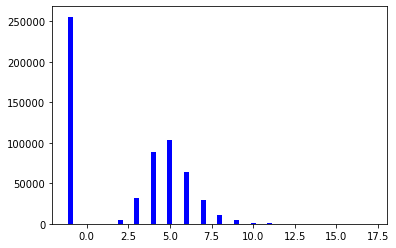

In [10]:
#--7--
#Identify author with highes amount of collaborations and calculate histogram of Erdos number for that person

#detect highest degree node
highest_degree_node = max(graph.degree, key=lambda x: x[1])

#print it
print(highest_degree_node)

#calculate erdos number for every node
erdos_numbers = {}

for author in graph:
    try:
        erdos_numbers[author] = nx.shortest_path_length(graph,highest_degree_node[0],author)
    except nx.NetworkXNoPath:
        erdos_numbers[author] = -1
        
#print(erdos_numbers)
container = {}

# count occurancance of erdos numbers
for author in erdos_numbers:
    #print(author)
    if erdos_numbers[author] in container:
        container[erdos_numbers[author]] = container[erdos_numbers[author]] + 1
    else:
        container[erdos_numbers[author]] = 1


print(container)

# Create histogram containing occurance of erdos numbers
plt.bar(container.keys(), container.values(), 0.3, color='b')

plt.show()

In [11]:
#--8-- preparation
#Calculate effective distance for all authors where possible (meaning that theya are connected)

file8 = open("8output.txt", "w", encoding="utf-8")
total_process = 1
lista = list(graph.nodes)
for item in lista:
    #print(item, total_process)
    n_neighbors = list(graph.neighbors(item))
    for n in n_neighbors:
        data = graph.get_edge_data(item, n, default=0)
        if data != 0:
            collabtimes = data["weight"] #fij = number of times authors i and j co-authored together
            Fi = len(n_neighbors) #Fi = the number of the total number of collaborations held by author i
            try:
                res = 1 - math.log((collabtimes / Fi), 10) #Calculate effective distance
            except Exception:    
                res = 0
            file8.writelines(item + ", " + n + ": " + str(res) + "\n")
        else: #Not needed
            res = 0
    total_process += 1

#--8-- Analysis
#Identify the authors corresponding to the ten most largest effective distances
file8 = open("8output.txt", "r", encoding="utf-8")

#Create dictionary where "Author1, Author2": effective_distance
d = {}
for line in file8.readlines():
    sp = line.strip("\n").split(":")
    d[sp[0]] = float(sp[-1].strip(" "))

#Get top 10
top10 = sorted(d, key=d.get, reverse=True)[:10]

for a in top10:
    #Print top 10
    print(a, d[a])

Wei Wang, Guopeng Zhang 3.4996870826184034
Wei Wang, Hailin Zhang 3.4996870826184034
Wei Wang, Liqiang Zhao 3.4996870826184034
Wei Wang, Li Cong 3.4996870826184034
Wei Wang, Hang Guo 3.4996870826184034
Wei Wang, Jidong Chen 3.4996870826184034
Wei Wang, Peng Zhang 3.4996870826184034
Wei Wang, Runsheng Wang 3.4996870826184034
Wei Wang, Weidong Yang 3.4996870826184034
Wei Wang, Qingming Wang 3.4996870826184034


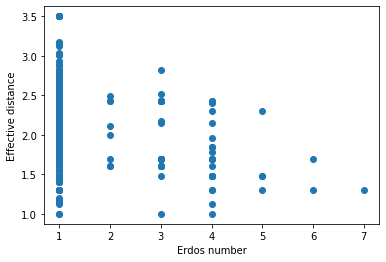

In [12]:
#--9--
#Discuss the results of dij with respect to Erdos number and comment whether possible connection exists between the two concepts


erdosfile = open("erdos.txt", "r", encoding="utf-8")
effectdist = open("8output.txt", "r", encoding="utf-8")

weis_neighbors = []
effectivdict = {}
#Erdos numbers only calculated for Wei Wang -> Find all effective distances related to him
for line in effectdist.readlines():
    if "Wei Wang" in line:
        spr = line.strip("\n")
        sp = re.split(",|:", spr)
        
        for i in range(len(sp)):
            sp[i] = sp[i].strip(" ")

        if "Wei Wang" in sp[0]:
            weis_neighbors.append(sp[1])
            effectivdict[sp[1]] = float(sp[2])
        elif "Wei Wang" in sp[1]:
            weis_neighbors.append(sp[0])
            effectivdict[sp[0]] = float(sp[2])
        

weis_neighbors = list(dict.fromkeys(weis_neighbors)) #strip duplicates
effectdist.close()

#Get corresponding erdos numbers
erdoses = json.loads(erdosfile.readline())
x = []
y = []
for neighbor in weis_neighbors:
    try:
        erdos = erdoses[neighbor]
        effe = effectivdict[neighbor]
        x.append(erdos)
        y.append(effe)
    except Exception:
        pass

#Scatterplot of their relation
plt.scatter(x=x, y=y)
plt.xlabel("Erdos number")
plt.ylabel("Effective distance")
plt.show()